In [4]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [5]:
bond1 = 'Price History_20+_US_TBills.xlsx'
bond2 = 'Price History_7-10_US_TBills.xlsx'
equity = 'Price History_IVV_US_Equity.xlsx'
gold = 'Price History_IAU_Gold_Trust.xlsx'
# Load the Excel file into a DataFrame
df = pd.read_excel(bond1)


In [28]:
def mean_variance_optimization(file_paths, initial_money):
    """
    Implements Mean-Variance Optimization (MVO) to allocate portfolio weights.
    Args:
        file_paths (list): List of file paths to the Excel files for each asset.
        initial_money (float): Total initial amount of money to invest.
    Returns:
        dict: Final portfolio value, optimized weights, and performance metrics.
    """
    # Remove duplicate file paths
    unique_file_paths = list(set(file_paths))
    
    # Load data and calculate daily returns for each asset
    returns_data = []
    for file_path in unique_file_paths:
        # Load Excel file into DataFrame
        data = pd.read_excel(file_path)
        data['Exchange Date'] = pd.to_datetime(data['Exchange Date'], errors='coerce')
        data['Close'] = pd.to_numeric(data['Close'], errors='coerce')
        data = data.dropna(subset=['Exchange Date', 'Close'])
        data = data.sort_values(by='Exchange Date')  # Sort by date

        # Calculate daily returns
        data['Daily Return'] = data['Close'].pct_change().dropna()
        returns_data.append(data[['Exchange Date', 'Daily Return']].set_index('Exchange Date'))
    
    # Combine all assets' returns into one DataFrame
    combined_returns = pd.concat(returns_data, axis=1, keys=[f"Asset_{i}" for i in range(len(returns_data))])
    combined_returns.columns = [f"Asset_{i}" for i in range(len(returns_data))]
    combined_returns = combined_returns.dropna()  # Drop rows with missing values

    # Calculate mean returns and covariance matrix
    mean_returns = combined_returns.mean()
    cov_matrix = combined_returns.cov()

    # --- Diagnostic: Print Mean Returns and Volatilities ---
    print("Mean Returns for each asset:")
    print(mean_returns)
    print("\nVolatility (Standard Deviation) for each asset:")
    print(combined_returns.std())

    # --- Diagnostic: Print Covariance and Correlation Matrix ---
    print("\nCovariance Matrix:")
    print(cov_matrix)
    print("\nCorrelation Matrix:")
    print(combined_returns.corr())

    # Define optimization functions
    def portfolio_variance(weights):
        return np.dot(weights.T, np.dot(cov_matrix, weights))

    def portfolio_return(weights):
        return np.dot(weights, mean_returns)

    # Constraints and bounds
    num_assets = len(mean_returns)
    constraints = [{'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}]  # Sum of weights = 1
    bounds = [(0, 1) for _ in range(num_assets)]  # No short-selling

    # Initial guess (equal weights)
    initial_weights = np.array([1 / num_assets] * num_assets)

    # --- Optional: Use Sharpe Ratio Objective Instead of Variance ---
    # Objective function to maximize Sharpe Ratio
    def sharpe_ratio(weights):
        portfolio_return_value = np.dot(weights, mean_returns)
        portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        return -portfolio_return_value / portfolio_volatility  # Negative for minimization in scipy

    # Run the optimization
    result = minimize(sharpe_ratio, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)
    
    if not result.success:
        raise ValueError("Optimization failed: " + result.message)
    
    optimized_weights = result.x

    # Calculate portfolio value over time using cumulative product of returns
    portfolio_returns = (combined_returns @ optimized_weights)
    portfolio_values = (1 + portfolio_returns).cumprod() * initial_money  # Cumulative product of returns

    # Metrics
    starting_value = initial_money
    ending_value = portfolio_values.iloc[-1]
    total_days = (portfolio_values.index[-1] - portfolio_values.index[0]).days
    total_years = total_days / 365.0
    
    # 1. CAGR
    cagr = ((ending_value / starting_value) ** (1 / total_years)) - 1
    
    # 2. Volatility (Standard Deviation of Daily Returns)
    volatility = portfolio_returns.std() * np.sqrt(252)  # Annualized volatility
    
    # 3. Max Drawdown
    rolling_max = portfolio_values.cummax()
    drawdowns = (portfolio_values - rolling_max) / rolling_max
    max_drawdown = drawdowns.min()
    
    # 4. Sharpe Ratio (assuming risk-free rate = 0 for simplicity)
    sharpe_ratio_value = portfolio_returns.mean() / portfolio_returns.std() * np.sqrt(252)
    
    # 5. Value at Risk (99% Confidence)
    var_99 = portfolio_returns.quantile(0.01)  # 1st percentile of returns

    # Plot portfolio value over time
    plt.figure(figsize=(14, 7))
    plt.plot(portfolio_values.index, portfolio_values, label='Portfolio Value (MVO)', color='green')
    plt.title("Portfolio Growth Over Time (Mean-Variance Optimization)")
    plt.xlabel("Date")
    plt.ylabel("Portfolio Value (USD)")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

    # Return metrics and results
    return {
        "Final Portfolio Value": f"${ending_value:,.2f}",
        "Optimized Weights": {f"Asset_{i}": f"{weight:.2%}" for i, weight in enumerate(optimized_weights)},
        "CAGR": f"{cagr:.2%}",
        "Volatility": f"{volatility:.2%}",
        "Max Drawdown": f"{max_drawdown:.2%}",
        "Sharpe Ratio": f"{sharpe_ratio_value:.2f}",
        "99% VaR": f"{var_99:.2%} (daily loss threshold)"
    }

In [39]:
capital = 1000000
files = [gold, equity]

Mean Returns for each asset:
Asset_0    0.000401
Asset_1    0.000415
dtype: float64

Volatility (Standard Deviation) for each asset:
Asset_0    0.011959
Asset_1    0.011105
dtype: float64

Covariance Matrix:
          Asset_0   Asset_1
Asset_0  0.000143  0.000007
Asset_1  0.000007  0.000123

Correlation Matrix:
          Asset_0   Asset_1
Asset_0  1.000000  0.052184
Asset_1  0.052184  1.000000


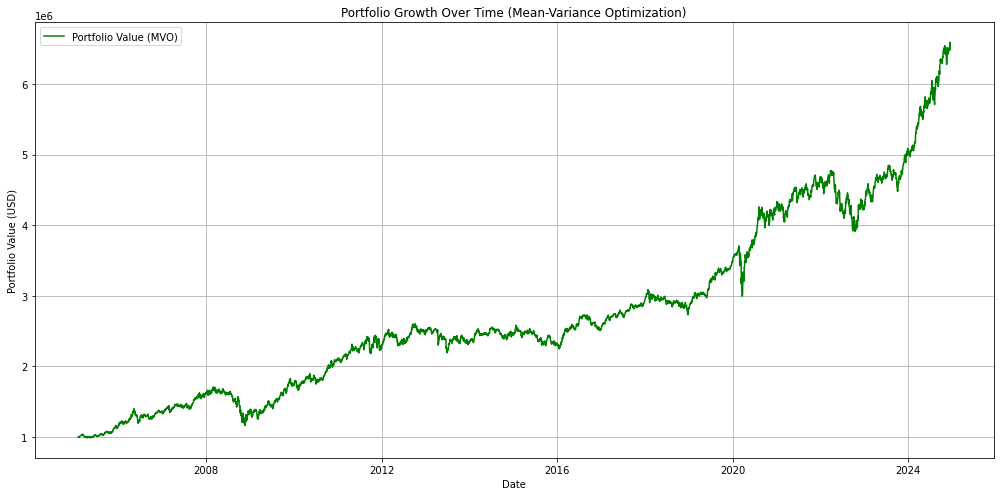

{'Final Portfolio Value': '$6,483,542.88',
 'Optimized Weights': {'Asset_0': '45.11%', 'Asset_1': '54.89%'},
 'CAGR': '9.86%',
 'Volatility': '13.25%',
 'Max Drawdown': '-31.82%',
 'Sharpe Ratio': '0.78',
 '99% VaR': '-2.23% (daily loss threshold)'}

In [40]:
mean_variance_optimization(files, capital)